# STEP 1: Pre-processing

## Import necessary packages

In [1]:
import os

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # Python has packages for specific domains: torchvision, torchaudio, torchtext. These include datasets among others.

## Data transformation and retrieval

Here we will use the MNIST dataset, which we can load using a dedicated PyTorch module 'Dataset'.
The Dataset module includes many built in datasets (full list: https://pytorch.org/vision/stable/datasets.html), but also supports custom datasets.
Upon calling this module we will specify data transformations we want to apply.

In the transforms.Compose function you can define other transformations to resize, centre or normalize the input data. 
For example if you would want to use the pretrained AlexNet architecture, you need to adjust the data to fit the input of the model. https://pytorch.org/hub/pytorch_vision_alexnet/

In [2]:
# Define a series of transformations to apply to the input images
transformations = transforms.Compose([
    # Convert the image to a PyTorch tensor. This also effectively changes the value range from 0-255 to 0-1. 
    transforms.ToTensor(),
])

# We then download the data using the specified transformations
download_path = os.path.join("data") # Specify location to store MNIST data. This is an OS-friendly way of specifying the path. Change as desired.
# Create the folder if doesn't exist.
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Create a dataset for training
train_data = datasets.MNIST(
    root= download_path, 
    train=True,
    download=True,
    transform=transformations
)

# Create a dataset for testing (train=False!)
test_data = datasets.MNIST(
    root= download_path,
    train=False,
    download=True,
    transform=transformations
)

## PyTorch DataLoader
PyTorch has another module called DataLoader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
This module helps with sampling and iterating over the Dataset object created earlier. This also helps with sampling batches of images during training, instead of feeding single images.
Additionally, it uses Python's multiprocessing functionality to sample data faster.

with shuffle = true we tell the dataloader to shuffle the images after each epoch to create different batches each time all the data has passed through the network

In [3]:
# Specify the batch size
batch_size = 64

# Create dataloaders for the training and test datasets respectively
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

The DataLoader is a generator, meaning that it does not store its contents in memory (as with a Python list).
In order to access its contents we need to loop over it, or alternatively call a batch with next(iter(DataLoader object))

In [4]:
# Printing the dataloader object directly won't show its contents. Instead you see where the object itself is stored in memory.
print(train_loader)

NOTE: make output shorter

In [5]:
# Let's have a look at what it yields.
sample = next(iter(train_loader))
sample

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

The Dataloader returns both the image data, and the corresponding labels.
Let's split these up and take a closer look at the structure of these variables.

In [6]:
sample_images, sample_labels = next(iter(train_loader))
print(f"Sample_data shape: {sample_images.shape}")
print(f"Sample_labels shape: {sample_labels.shape}")

Sample_data shape: torch.Size([64, 1, 28, 28])
Sample_labels shape: torch.Size([64])


As you can see, both variables are batches of 64. The image has 1 channel (e.g., RGB requires 3) with a size of 28 by 28 pixels.
Looking at 'sample_labels', we can see it contains the true digit labels of the corresponding images.

In [7]:
sample_labels

tensor([6, 1, 9, 8, 5, 1, 1, 4, 4, 4, 5, 2, 6, 1, 7, 4, 9, 5, 4, 8, 2, 9, 3, 7,
        8, 3, 0, 5, 4, 9, 7, 8, 8, 0, 3, 1, 8, 7, 6, 2, 4, 6, 9, 5, 1, 5, 1, 2,
        9, 3, 4, 9, 3, 4, 2, 8, 1, 4, 2, 7, 8, 9, 7, 2])

Let's check the first image as an example

Now this shows a colored image? but we have greyscale images?

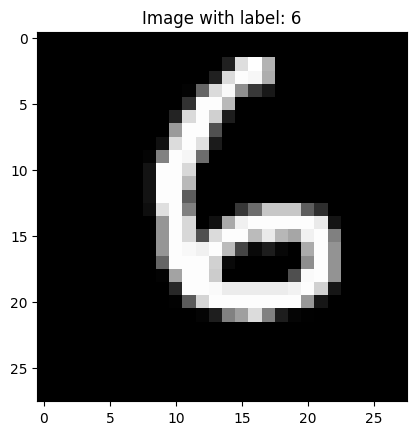

In [8]:
im_id = 0

plt.imshow(sample_images[im_id].permute((1,2,0)), cmap='gray')
plt.title(f"Image with label: {sample_labels[im_id]}")
plt.show()

# STEP 2: Create the model

## Check Device for Training
Depending on your system, you can choose whether to train the model on your CPU (Central Processing Unit) or GPU (Graphical Processing Unit).
Choosing to run the training process on your GPU will significantly increase the training speed. In PyTorch you can set the device to 'cuda' (Compute Unified Device Architecture), which is a sort of software interface that allows for general purpose computing on certain types of GPUs.

NOTE: 
Mention that if you use CUDA, you need to send the data and the model also to this device. Otherwise you cannot make use of the GPU

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Configures to cuda if it is available.
print(f"Using {device} device")

Using cuda:0 device


## The Model Architecture: simple network
Firstly, we need to define the model architecture. In other words, we need to define the amount and types of layers, in which order they are arranged, and how many inputs and outputs there are for each layer. Additionally, we define the activation functions that make the model non-linear. All this information is organized by means of a Python class. The model architecture will thus be contained within an object. 

NOTE: Not sure if the final two sentences are making things clear....

- Flatten: transforms a 2d input to one dimension (see example below)
- Linear: fully connected layer
- ReLu: activation function to introduce non-linearity into the network, applies max(0,x)

(nog meer uitleggen ook wat die init, en super is enzo)
Misschien dit?:
The class we are writing inherits class attributes and functions from the nn.Module class (within the parentheses), which essentially makes it easier for us to define a trainable network.
When writing the code you have to first define the architecture under the \_\_init__ function. This code is run when you create an instance of the object. It is basically an initialization script (hence "\_\_init__"). 
We also need to initialize the nn.Module class that we inherit when we create an object from this class, this is what the super().\_\_init__() function does.

Lastly, the forward function defines the information flow from input to output. It is important to name this function as 'forward'.
This is because PyTorch uses the forward method internally when you call an instance of your model.


In [10]:
#create model structure
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Example of how the Flatten function works

In [11]:
sample_image, sample_label = next(iter(test_loader))
sample_image.to(device)
flatten = nn.Flatten()
output = flatten(sample_image)
output.size()

torch.Size([64, 784])

Example of how the linear layer works

NOTE ben niet zeker of dit nuttig/nodig is

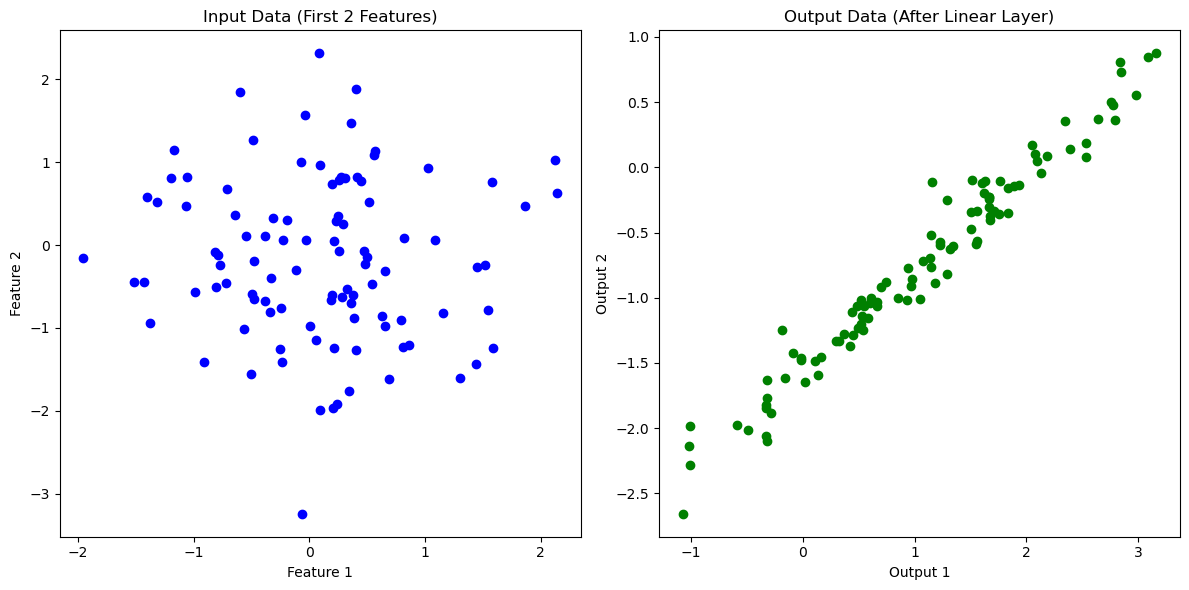

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)

# Generate random input data (100 samples, each with 3 features)
input_data = np.random.randn(100, 3)

# Initialize random weights (3 inputs -> 2 outputs) and biases (2 outputs)
weights = np.random.randn(3, 2)
biases = np.random.randn(2)

# Define the linear layer function
def linear_layer(x, w, b):
    return np.dot(x, w) + b

# Apply the linear layer to the input data
output_data = linear_layer(input_data, weights, biases)

# Plot the first two input features and their corresponding outputs
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Input data plot
axs[0].scatter(input_data[:, 0], input_data[:, 1], color='blue')
axs[0].set_title("Input Data (First 2 Features)")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")

# Output data plot
axs[1].scatter(output_data[:, 0], output_data[:, 1], color='green')
axs[1].set_title("Output Data (After Linear Layer)")
axs[1].set_xlabel("Output 1")
axs[1].set_ylabel("Output 2")

plt.tight_layout()
plt.show()

Example of how the ReLU activation function works.
This function allows the network to learn more complex patterns in the data, by introducing non-linearities. Furthermore, it helps with the vanishing gradient problem. This can occur during backpropagation, when the gradients that are used to update the network become close to 0 when going from the later to the earlier layers.
for more information about the ReLU function: https://medium.com/@meetkp/understanding-the-rectified-linear-unit-relu-a-key-activation-function-in-neural-networks-28108fba8f07


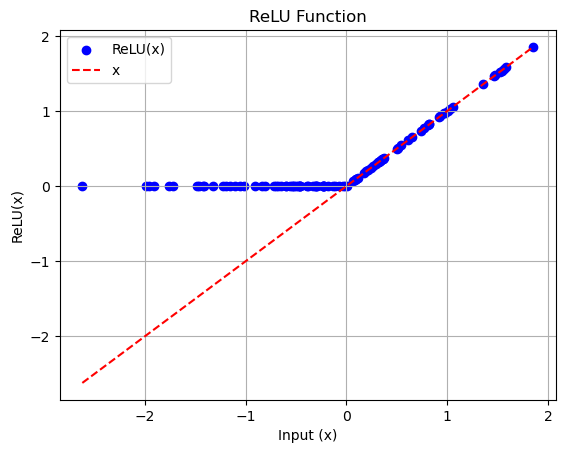

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate random data (100 points from a normal distribution)
np.random.seed(42)
random_data = np.random.normal(0, 1, 100)

# Apply the ReLU function to the random data
relu_data = relu(random_data)

# Plot the original data vs ReLU-transformed data
plt.scatter(random_data, relu_data, color='blue', label='ReLU(x)')
plt.plot(sorted(random_data), sorted(random_data), color='red', linestyle='dashed', label='x')
plt.title("ReLU Function")
plt.xlabel("Input (x)")
plt.ylabel("ReLU(x)")
plt.legend()
plt.grid(True)
plt.show()

## convolutional network
To classify images (especially more naturalistic once) you might want to add convolutional layers to increase the performance of the model. 
Here you see the architecture of a simple model with one convolutional layer. 

If there is time left, we will come back to this and explain how it works. Otherwise, you can read through this explanation yourself if you are interested.

A convolutional neural network is a network that learns features by applying filters (or kernels) to its input and updating those. This characteristic makes convolutional layers especially useful to classify (naturalistic) images. 

The network below contains 1 convolutional layer
- nn.conv2d means that we two dimensions.
    - in_channels = 1: for grayscale pictures ( this would be 3 in the case of coloured pictures (rgb)).
    - out_channels = 10: we will apply 10 filters 
    - kernel_size = 3: these filters will have have a size of 3x3
    - stride = 1we will move the filter by one pixel each time

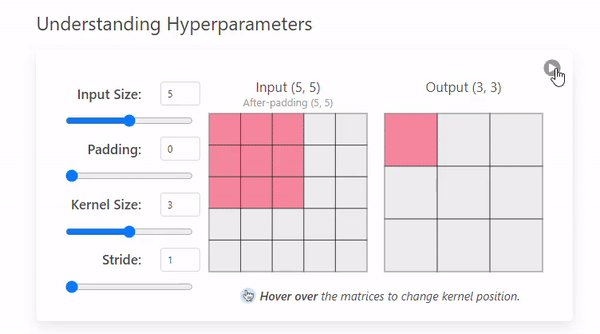 

- nn.BatchNorm2d is to normalize the output
- next we apply a ReLu activation function to the output
- Laslty we apply Max Pooling, with size 3x3 and stride 2, which means that for each 3x3 square the network will only store the maximum value

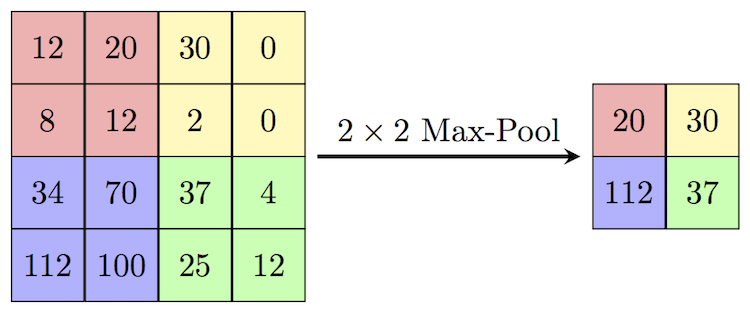

In the forward part of the code, it is important to flatten the output from the convolutional layer, as the linear layer only takes one dimension as input.

If you want a more elaborate (and maybe clearer) explanation of how convolution works, you can check out this video:
https://www.youtube.com/watch?v=KuXjwB4LzSA&t=703s


NOTE: 
- Maybe explain better what a filter or kernel does?
- Why do we have to normalize the output? (BatchNorm2d layer)
- Why do we need Max Pooling? Or pooling layers in general?



In [12]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10 , kernel_size = 3, stride = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
            )
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10*12*12, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

Choose which model you want to use:

In [13]:
# model = SimpleNeuralNetwork()
model = ConvNeuralNetwork()
print(model)

ConvNeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1440, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


# Step 3: Prepare the training and testing of the model
## Define function to train the model
First we will define a function to train the model. This functions takes as input: 
- the dataloader: in this case that will be the dataloader with the training data
- the model architecture
- the loss function, which computes the dissimilarity between the network's predictions (pred) and the actual answer (y)
- the optimizer functions, which computes the gradient based on the losses (dit moet anders verwoord zijn denk ik)
- the current epoch to track the network's performance

We set the model to training mode (model.train). This is very important because this allows gradients to be computed for the model parameters, during the forward and backward passes in the training. It also activates training-specific features like dropout and batch normalization to prevent overfitting and improve generalization when working with more complex networks.

For each batch in the dataloader:
1. we pass the input (X) through the model.
2. The loss function calculates the dissimilarities between the prediction and the actual answer (y).
3. the gradients of the losses are computed by taking the derivatives of the loss functions for each parameter (loss.backward).
4. The optimizer than adjusts the parameters with these gradients (optimizer_step)
5. the gradients are set back to zero to prevent the gradients to keep adding up across batches (optimizer.zero_grad).
6. for each 10 and 100 batches we track the losses/progress of the training



In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        #track the losses for visualization
        if batch % 10 == 0:
            train_losses.append(loss.item())
            train_counter.append((batch*64) + (epoch*len(dataloader.dataset)))

        #track progress of the training
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



## Define function to test the model:
Next we define a function to test the model. This function takes as input: 
- the dataloader: in this case that will be the dataloader with the test data
- the model architecture
- the loss function
(we don't need the optimizer function, since we won't update the parameters anymore.)

We set the model to evaluation mode (model.eval), this is important because at this will disable dropout and will use the batch normalizations calculated during the training phase.

We initiate two empty variables to keep track of the model's performance

We evaluate the model with torch.no_grad() to ensure that no gradients are computed during test mode (this also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True).

We need both model.eval() and torch.no_grad() during the test phase since model.eval changes the state of the nn.Module whereas torch.no_grad is a context manager to work with the autograd engine.

We store the losses and correct answers to compute the accuracy and average loss of the model.


In [15]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# Step 5: Train the model

## Defining the hyperparameters
Start by defining the hyperparameters:
- epochs: the number of epochs = number of times that the training dataset is passed through the model
- learning rate: value indicating to which extent the model parameters are updated for each batch/epoch (smaller values lead to slower updating).
- loss function: PyTorch has different build in functions to calculate the losses
- optimizer function: PyTorch has different build in functions for optimization

Here we will use CrossEntropyLoss as the loss function. This function applies a softmax transformation to the models output to obtain the predicted class probabilities. Afterwards it computes the negative log-likelihood loss between the predicted probabilities and the true labels.

For the optimizer we use stochastic gradient descent. (leggen we dat hier nog verder uit?)

Next we will initiate a couple of empty lists to keep track of the network's performance

NOTE:
- Dat stukje over de loss functie en de optimizer is misschien wat ingewikkeld nog om te begrijpen.

In [16]:
#define hyperparameters
epochs = 1
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss() #this step applies the softmax transformation and can compare the output of the model with integers
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

## Test the untrained model
First we test the untrained model, which performance do you expect?

In [17]:
#test the untrained model
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 9.0%, Avg loss: 2.305499 



## Now everything is ready to train and test the network! 
We use a for loop to repeat the process for n epochs using the functions we created previously.
After each training loop, we use the test loop to check the performance of the model.
Note that the model thus also sees the test data for several times. 
To have a true evaluation of the model, you would actually need data that the model has never seen before (you could do this by splitting the data in the beginning when creating the dataloaders).

In [18]:
#train the model
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, t)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.293697  [   64/60000]
loss: 2.212678  [ 6464/60000]
loss: 2.158701  [12864/60000]
loss: 2.067483  [19264/60000]
loss: 1.946012  [25664/60000]
loss: 1.803340  [32064/60000]
loss: 1.665448  [38464/60000]
loss: 1.547063  [44864/60000]
loss: 1.367304  [51264/60000]
loss: 1.280680  [57664/60000]
Test Error: 
 Accuracy: 80.9%, Avg loss: 1.155838 

Done!


## Visualize the model's progress
Now we can create a graph to see how the losses of the model go down.

Text(0, 0.5, 'negative log likelihood loss')

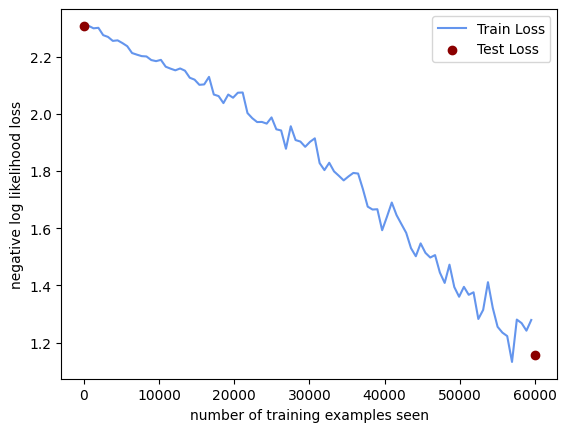

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='cornflowerblue', linewidth=1.5)
plt.scatter(test_counter, test_losses, zorder = 5, color='darkred')         
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

# Save the model

Lastly, you can store the network in different ways, depending on whether you only want to save its architecture, or just the trained weights and biases.

The recommended way is to just store the parameters, because this allows for the most flexibility. Saving the entire model is less flexible and requires extra caution when working across devices.

## Saving and loading the parameters
This method will save just the trained parameters. Upon loading the model it is required to create an instance of the original network architecture and then load the parameters to this model.

In [20]:
# Store the network parameters
torch.save(model.state_dict(), 'modelMNIST_pars.pth')

In [21]:
# This is how you load it 
loaded_model = ConvNeuralNetwork()
loaded_model.load_state_dict(torch.load("modelMNIST_pars.pth", weights_only=True))
# Don't forget to put the model in evaluation mode
loaded_model.eval()

ConvNeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1440, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Saving and loading the entire model

In [ ]:
#save  model
torch.save(model, 'modelMNIST.pth')

#if you would want to load the model again
model = torch.load('modelMNIST.pth')
